In [1]:
#import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
# load data
df = pd.read_csv('boston.csv')
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [7]:
# 1. Split data train - validate - testing

from sklearn.model_selection import train_test_split

feature = df.drop(columns='medv')
target = df[['medv']]

feature_medv_pretrain, feature_medv_test, target_medv_pretrain, target_medv_test = train_test_split(feature, target, test_size=0.20, random_state=42)

feature_medv_train, feature_medv_validation, target_medv_train, target_medv_validation = train_test_split(feature_medv_pretrain, target_medv_pretrain, test_size=0.20, random_state=42)


In [8]:
# 2. Draw correlation plot on training data and perform feature selection on highly correlated features

## calculate VIF scores

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif 
from statsmodels.tools.tools import add_constant

X = add_constant(feature_medv_train)

vif_df = pd.DataFrame([vif(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,feature,vif_score
1,crim,1.750939
2,zn,2.473421
3,indus,3.741988
4,chas,1.110042
5,nox,4.585650
6,rm,1.972174
7,age,3.127443
8,dis,4.390458
9,rad,7.182410
10,tax,8.268145


Ada beberapa fitur dengan skor VIF tinggi:

1. 'indus'
2. 'nox'
3. 'age'
4. 'dis'
5. 'rad'
6. 'tax'
7. 'Istat'

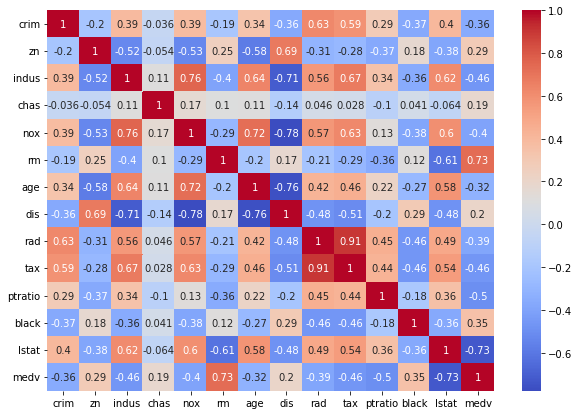

In [15]:
# heatmap correlation

medv_train = pd.concat([feature_medv_train, target_medv_train], axis=1)
corr = medv_train.corr()

plt.figure(figsize=(10,7))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

from above correlation plot, can we see (tax) and (rad) are *highly correlated features*. We choose retain (tax), therefore we need to drop (rad)

In [16]:
# Drop Multicollinear Features
feature_medv_train = feature_medv_train.drop(columns=['rad'])
feature_medv_validation = feature_medv_validation.drop(columns=['rad'])
feature_medv_test = feature_medv_test.drop(columns=['rad'])

# 3. Train Multiple Models
with different alpha (lambda)

Ridge Regression

In [27]:
from sklearn.linear_model import Ridge

# train the model
X_medv_train = feature_medv_train.to_numpy()
y_medv_train = target_medv_train.to_numpy()
y_medv_train = y_medv_train.reshape(len(y_medv_train),)

# define the model
ridge_reg_pointzeroone = Ridge(alpha=0.01, random_state=42)
ridge_reg_pointone = Ridge(alpha=0.1, random_state=42)
ridge_reg_one = Ridge(alpha=1, random_state=42)
ridge_reg_ten = Ridge(alpha=10, random_state=42)

# fit the model (training)
# A stochastic gradient descent
# backpropagation algo
ridge_reg_pointzeroone.fit(X_medv_train, y_medv_train)
ridge_reg_pointone.fit(X_medv_train, y_medv_train)
ridge_reg_one.fit(X_medv_train, y_medv_train)
ridge_reg_ten.fit(X_medv_train, y_medv_train)

Ridge(alpha=10, random_state=42)

Lasso

In [28]:
from sklearn.linear_model import Lasso

# train the model
X_medv_train = feature_medv_train.to_numpy()
y_medv_train = target_medv_train.to_numpy()
y_medv_train = y_medv_train.reshape(len(y_medv_train),)

# define the model
lasso_reg_pointzeroone = Lasso(alpha=0.01, random_state=42)
lasso_reg_pointone = Lasso(alpha=0.1, random_state=42)
lasso_reg_one = Lasso(alpha=1, random_state=42)
lasso_reg_ten = Lasso(alpha=10, random_state=42)

# fit the model (training)
# A stochastic gradient descent
# backpropagation algo
lasso_reg_pointzeroone.fit(X_medv_train, y_medv_train)
lasso_reg_pointone.fit(X_medv_train, y_medv_train)
lasso_reg_one.fit(X_medv_train, y_medv_train)
lasso_reg_ten.fit(X_medv_train, y_medv_train)

Lasso(alpha=10, random_state=42)

# 4. Choose the best lambda from validation data set

In [29]:
from sklearn.metrics import mean_squared_error

X_medv_validation = feature_medv_validation.to_numpy()
y_medv_validation = target_medv_validation.to_numpy()
y_medv_validation = y_medv_validation.reshape(len(y_medv_validation),)

alphas = [0.01, 0.1, 1., 10]
models = [ridge_reg_pointzeroone,
          ridge_reg_pointone,
          ridge_reg_one,
          ridge_reg_ten]

for model, alpha in zip(models, alphas):
    y_predict_validation = model.predict(X_medv_validation)
    rmse = np.sqrt(mean_squared_error(y_medv_validation,y_predict_validation))
    print(f'RMSE of Ridge regression model with alpha = {alpha} is {rmse}')

RMSE of Ridge regression model with alpha = 0.01 is 4.960676932957843
RMSE of Ridge regression model with alpha = 0.1 is 4.949412535122791
RMSE of Ridge regression model with alpha = 1.0 is 4.912351371579991
RMSE of Ridge regression model with alpha = 10 is 4.871717983886228


from the validation data set, we can choose the best lambda is 10 for ridge regression

In [30]:
from sklearn.metrics import mean_squared_error

X_medv_validation = feature_medv_validation.to_numpy()
y_medv_validation = target_medv_validation.to_numpy()
y_medv_validation = y_medv_validation.reshape(len(y_medv_validation),)

alphas = [0.01, 0.1, 1., 10]
models = [lasso_reg_pointzeroone,
          lasso_reg_pointone,
          lasso_reg_one,
          lasso_reg_ten]

for model, alpha in zip(models, alphas):
    y_predict_validation = model.predict(X_medv_validation)
    rmse = np.sqrt(mean_squared_error(y_medv_validation,y_predict_validation))
    print(f'RMSE of Lasso model with alpha = {alpha} is {rmse}')

RMSE of Lasso model with alpha = 0.01 is 4.934105658639752
RMSE of Lasso model with alpha = 0.1 is 4.907145314259478
RMSE of Lasso model with alpha = 1.0 is 4.845855910636398
RMSE of Lasso model with alpha = 10 is 5.426622694252769


from the validation data set, we can choose the best lambda is 1.0 for lasso

# 4. Interpret a sample of the coefficients of the best model

Coeeficient tour

In [32]:
model = ridge_reg_ten

coef_df = pd.DataFrame({
    'feature':['intercept'] + feature_medv_train.columns.tolist(),
    'coefficient':[model.intercept_] + list(model.coef_)
})

coef_df

,feature,coefficient
0,intercept,15.064666
1,crim,-0.071408
2,zn,0.033030
3,indus,-0.067858
4,chas,1.955801
5,nox,-1.568248
6,rm,4.783168
7,age,-0.011523
8,dis,-1.260056
9,tax,-0.001976


In [33]:
model = lasso_reg_one

coef_df = pd.DataFrame({
    'feature':['intercept'] + feature_medv_train.columns.tolist(),
    'coefficient':[model.intercept_] + list(model.coef_)
})

coef_df

,feature,coefficient
0,intercept,25.823435
1,crim,-0.041076
2,zn,0.025273
3,indus,-0.000000
4,chas,0.000000
5,nox,-0.000000
6,rm,2.504122
7,age,0.022055
8,dis,-0.599362
9,tax,-0.002994


# Model Evaluation

Ridge Best Model

In [34]:
ridge_best = ridge_reg_ten

coef_df = pd.DataFrame({
    'feature':['intercept'] + feature_medv_train.columns.tolist(),
    'coefficient':[ridge_best.intercept_] + list(ridge_best.coef_)
})

coef_df

,feature,coefficient
0,intercept,15.064666
1,crim,-0.071408
2,zn,0.033030
3,indus,-0.067858
4,chas,1.955801
5,nox,-1.568248
6,rm,4.783168
7,age,-0.011523
8,dis,-1.260056
9,tax,-0.001976


Lasso Best Model

In [35]:
lasso_best = lasso_reg_one

coef_df = pd.DataFrame({
    'feature':['intercept'] + feature_medv_train.columns.tolist(),
    'coefficient':[lasso_best.intercept_] + list(lasso_best.coef_)
})

coef_df

,feature,coefficient
0,intercept,25.823435
1,crim,-0.041076
2,zn,0.025273
3,indus,-0.000000
4,chas,0.000000
5,nox,-0.000000
6,rm,2.504122
7,age,0.022055
8,dis,-0.599362
9,tax,-0.002994


So, the best model use Ridge regression when alpha is 10, and the best model use lasso regression when alpha is 1

# Diagnostic Study

# Ridge Regression  Best Model

In [36]:
from sklearn.metrics import r2_score

y_predict_train = ridge_best.predict(X_medv_train)

print('R-squared for training data is {}'.format(r2_score(y_predict_train, y_medv_train)))

R-squared for training data is 0.6542246087727177


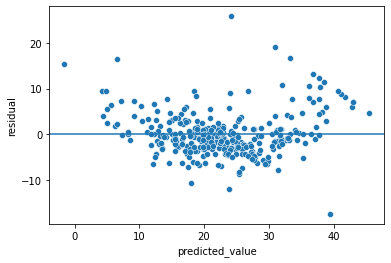

In [37]:
# calculate residuals
residual = y_medv_train - y_predict_train

# prepare dataframe
# 1 predictor --> predictor VS residual
df_resid = pd.DataFrame({
    'predicted_value': y_predict_train,
    'residual': residual
})

# residual plot
sns.scatterplot(data=df_resid, x="predicted_value", y="residual")
plt.axhline(0)
plt.show()

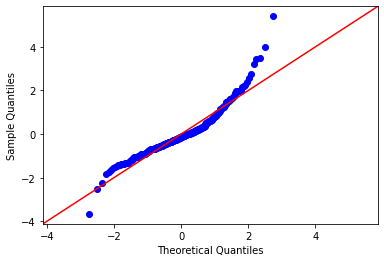

In [43]:
#QQ Plot
from sklearn.preprocessing import StandardScaler

std_resid = StandardScaler().fit_transform(residual.reshape(-1,1))
std_resid = np.array([value for nested_array in std_resid for value in nested_array])

import statsmodels.api as sm
sm.qqplot(std_resid, line='45')
plt.show()

# Training Error Ridge Regression

In [44]:
# prepare prediction result on train data
y_predict_train = ridge_best.predict(X_medv_train)

In [45]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for training data is {}'.format(np.sqrt(mean_squared_error(y_predict_train, y_medv_train))))
print('MAE for training data is {}'.format(mean_absolute_error(y_predict_train, y_medv_train)))
print('MAPE for training data is {}'.format(mean_absolute_percentage_error(y_predict_train, y_medv_train)))

RMSE for training data is 4.778640361040111
MAE for training data is 3.3776762058865626
MAPE for training data is 0.20627342943666688


# Testing Error Ridge Regression

In [46]:
# prepare prediction result on test data
X_medv_test = feature_medv_test.to_numpy()
y_predict_test = ridge_best.predict(X_medv_test)

# ground truth target
y_medv_test = target_medv_test.to_numpy()
y_medv_test = y_medv_test.reshape(len(y_medv_test),)

In [47]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for testing data is {}'.format(np.sqrt(mean_squared_error(y_predict_test, y_medv_test))))
print('MAE for testing data is {}'.format(mean_absolute_error(y_predict_test, y_medv_test)))
print('MAPE for testing data is {}'.format(mean_absolute_percentage_error(y_predict_test, y_medv_test)))

RMSE for testing data is 5.158908333657057
MAE for testing data is 3.2444816457044965
MAPE for testing data is 0.2622349874986081


# Interpretasi Ridge Regression

Best Model Ridge Regression:

1. Nilai RMSE mengalami peningkatan pada data testing
2. Nilai MAE mengalami penurunan pada data testing
3. Nilai MAPE mengalami peningkatan 6% pada data testing.

maka dari itu untuk best model Ridge resgression cukup baik untuk bisa digunakan karena akurasi model masih diatas 70%, tingkat kekeliruan model dapat diakibatkan oleh beberapa faktor yaitu :
Asusmsi linera regresion yang tidak terpenuhi
1. Checking linerarity ( tidak terpenuhi)
2. Constan residual varians ( tidak terpenuhi)
3. Uncorelated resusidual betwwen obesrvation ( tidak terpenuhi)
4. Normal distribusion (terpenuhi)

hanya 1 asumsi yang terpenuhi untuk linear regression


# Lasso Regression Best Model

In [48]:
from sklearn.metrics import r2_score

y_predict_train = lasso_best.predict(X_medv_train)

print('R-squared for training data is {}'.format(r2_score(y_predict_train, y_medv_train)))

R-squared for training data is 0.5133022055846548


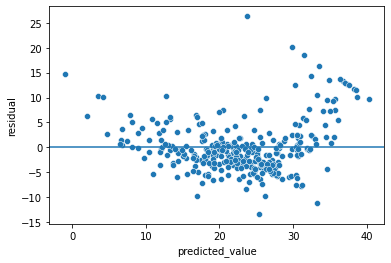

In [49]:
# calculate residuals
residual = y_medv_train - y_predict_train

# prepare dataframe
# 1 predictor --> predictor VS residual
df_resid = pd.DataFrame({
    'predicted_value': y_predict_train,
    'residual': residual
})

# residual plot
sns.scatterplot(data=df_resid, x="predicted_value", y="residual")
plt.axhline(0)
plt.show()

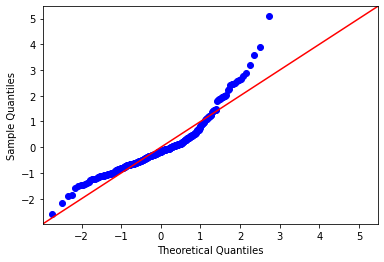

In [50]:
#QQ Plot
from sklearn.preprocessing import StandardScaler

std_resid = StandardScaler().fit_transform(residual.reshape(-1,1))
std_resid = np.array([value for nested_array in std_resid for value in nested_array])

import statsmodels.api as sm
sm.qqplot(std_resid, line='45')
plt.show()

# Training Error Lasso Regression

In [51]:
# prepare prediction result on training data
y_predict_train = lasso_best.predict(X_medv_train)

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for training data is {}'.format(np.sqrt(mean_squared_error(y_predict_train, y_medv_train))))
print('MAE for training data is {}'.format(mean_absolute_error(y_predict_train, y_medv_train)))
print('MAPE for training data is {}'.format(mean_absolute_percentage_error(y_predict_train, y_medv_train)))

RMSE for training data is 5.170346463296143
MAE for training data is 3.6858416211465084
MAPE for training data is 0.2295469115534592


# Testing Error Lasso Regression

In [52]:
# prepare prediction result on test data
X_medv_test = feature_medv_test.to_numpy()
y_predict_test = lasso_best.predict(X_medv_test)

# ground truth target
y_medv_test = target_medv_test.to_numpy()
y_medv_test = y_medv_test.reshape(len(y_medv_test),)

In [53]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for testing data is {}'.format(np.sqrt(mean_squared_error(y_predict_test, y_medv_test))))
print('MAE for testing data is {}'.format(mean_absolute_error(y_predict_test, y_medv_test)))
print('MAPE for testing data is {}'.format(mean_absolute_percentage_error(y_predict_test, y_medv_test)))

RMSE for testing data is 5.125494212319777
MAE for testing data is 3.3980507105960682
MAPE for testing data is 0.2950524268933147


# Interpretasi Lasso Regression

Best Model Ridge Regression:

1. Nilai RMSE mengalami penurunan pada data testing
2. Nilai MAE mengalami penurunan pada data testing
3. Nilai MAPE mengalami peningkatan 7% pada data testing.

maka dari itu untuk best model Ridge resgression cukup baik untuk bisa digunakan karena akurasi model masih diatas 70%, tingkat kekeliruan model dapat diakibatkan oleh beberapa faktor yaitu :
Asusmsi linear regresion yang tidak terpenuhi
1. Checking linerarity ( tidak terpenuhi)
2. Constan residual varians ( tidak terpenuhi)
3. Uncorelated resusidual betwwen obesrvation ( tidak terpenuhi)
4. Normal distribusion (tidak terpenuhi)




# Kesimpulan

Berdasarkan hasil testing nilai RMSE, MAE dan MAPE, maka dapat disimpulkan:

1. Nilai RMSE Ridge Regression > Lasso Regression
2. Nilai MAE Ridge Regression < Lasso Regression
3. Nilai MAPE Ridge Regression < Lasso Regression.

secara keseluruhan model Ridge Regression lebih baik dibandingkan dengan Lasso Regression